# Loading and Plotting Raw Signals #

## 1. Load librairies and functions ##

In [1]:
import mne
from mne.io import read_raw_fieldtrip
from mnelab.io import read_raw
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os
from scipy.signal import spectrogram
from copy import deepcopy

from scipy.signal import hann

from functions.utils import _get_onedrive_path

## 2. Set the paths ##

In [2]:
session_ID = 'sub002 DBS OFF rest'
DBS_status = 'DBS OFF'


working_path = os.getcwd()
onedrivepath = _get_onedrive_path()

# Set sourcepath and saving path:
subject_path = join(onedrivepath, session_ID[:6])
synced_data_path = join(subject_path, "synced_data")
session_synced_data_path = join(synced_data_path, session_ID)

#  Set saving path
results_path = join(working_path, "results")
saving_path = join(results_path, session_ID)
if not os.path.isdir(saving_path):
    os.makedirs(saving_path)


In [3]:
filename = 'SYNCHRONIZED_INTRACRANIAL_sub-002_ses-Fu12mMedOn01_task-Rest_acq-StimOff_mod-BrainSenseBip_run-1.set'
file = join(session_synced_data_path,filename)
raw = read_raw(file, preload=True)

In [4]:
raw_times = raw.times - raw.times[0]
picks = [raw.ch_names[0], raw.ch_names[1]]
fs = round(raw.info['sfreq'])
L_chan = raw.get_data(picks=raw.ch_names[0])[0]
R_chan = raw.get_data(picks=raw.ch_names[1])[0]
stim_L_chan = raw.get_data(picks=raw.ch_names[4])[0]
stim_R_chan = raw.get_data(picks=raw.ch_names[5])[0]
timescale = np.arange(0, len(L_chan)/fs, 1/fs)

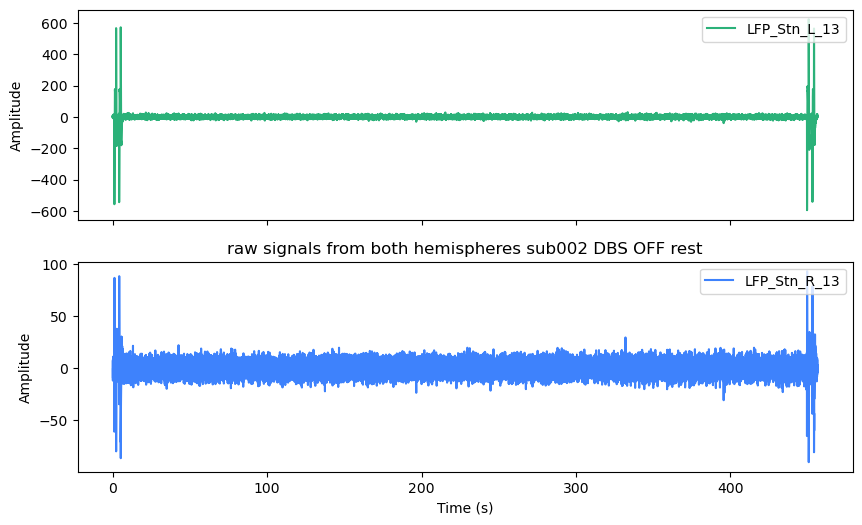

<Figure size 640x480 with 0 Axes>

In [20]:
%matplotlib inline
# plot raw signals
def plot_signals(times, data, chanlabels, session_ID, title):
    num_signals = len(chanlabels)
    fig, axes = plt.subplots(num_signals, 1, sharex=True, figsize=(10, 6))
    colors = ['xkcd:bluey green','xkcd:dodger blue']
    plt.title(title)

    for idx, (ax, label) in enumerate(zip(axes, chanlabels)):
        ax.plot(times, data[idx, :], label=label, color=colors[idx])
        ax.set_ylabel('Amplitude')
        ax.legend(loc='upper right')
    

    axes[-1].set_xlabel('Time (s)')  # Only set the x-axis label on the last subplot
    plt.show()

plot_signals(raw_times, raw.get_data(), picks, session_ID, title=('raw signals from both hemispheres ' + session_ID))
plt.savefig(join(saving_path, (session_ID + ' raw signals from both hemispheres.png')))


C:\Users\Juliette\AppData\Local\Temp\ipykernel_3416\3952595722.py:4: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window, sym=False)


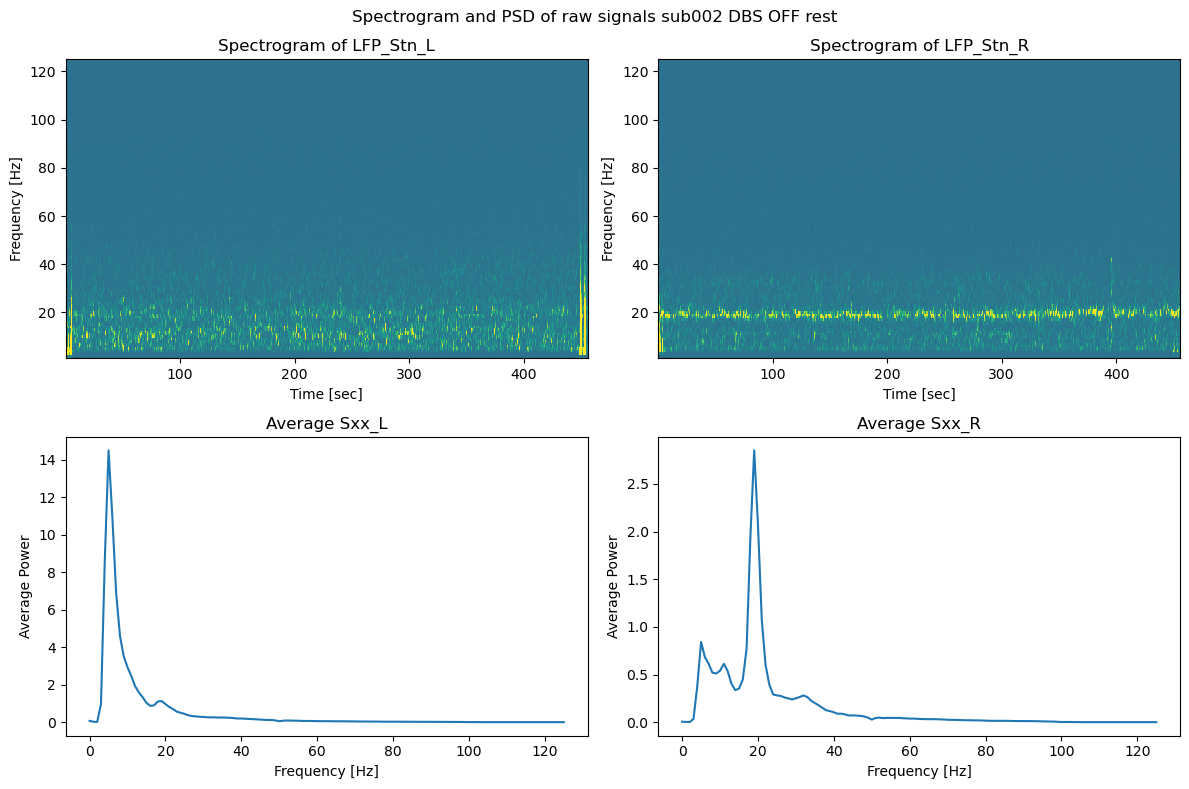

In [22]:
%matplotlib inline
window = fs # window length = 1 sec; frequencies will be from 0 to 125 Hz, 125Hz = Nyquist = fs/2
noverlap = window // 2 # 50% overlap of windows
window = hann(window, sym=False)

# Plot 1 data
frequencies_L, time_sectors_L, Sxx_L = spectrogram(x=L_chan, fs=fs, window=window, noverlap=noverlap, scaling='density', mode='psd', axis=0)

# Plot 2 data
frequencies_R, time_sectors_R, Sxx_R = spectrogram(x=R_chan, fs=fs, window=window, noverlap=noverlap, scaling='density', mode='psd', axis=0)

# Plot 3 data
average_Sxx_L = np.nanmean(Sxx_L, axis=1)
Sxx_std_L = np.std(Sxx_L, axis=1)  # standard deviation of each frequency row
Sxx_sem_L = Sxx_std_L / np.sqrt(Sxx_L.shape[1])

# Plot 4 data
average_Sxx_R = np.nanmean(Sxx_R, axis=1)
Sxx_std_R = np.std(Sxx_R, axis=1)  # standard deviation of each frequency row
Sxx_sem_R = Sxx_std_R / np.sqrt(Sxx_R.shape[1])

# Create a figure with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.title(session_ID)

# Plot 1: Top left
axs[0, 0].pcolormesh(time_sectors_L, frequencies_L, Sxx_L, vmin=-3, vmax=5)
#axs[0, 0].plot(timescale, stim_L_chan * 30, color='white')
axs[0, 0].set_ylim(1, 125)
axs[0, 0].set_ylabel('Frequency [Hz]')
axs[0, 0].set_xlabel('Time [sec]')
axs[0, 0].set_title('Spectrogram of LFP_Stn_L')

# Plot 2: Top right
axs[0, 1].pcolormesh(time_sectors_R, frequencies_R, Sxx_R, vmin=-3, vmax=5)
#axs[0, 1].plot(timescale, stim_R_chan * 30, color='white')
axs[0, 1].set_ylim(1, 125)
axs[0, 1].set_ylabel('Frequency [Hz]')
axs[0, 1].set_xlabel('Time [sec]')
axs[0, 1].set_title('Spectrogram of LFP_Stn_R')

# Plot 3: Bottom left
axs[1, 0].plot(average_Sxx_L)
axs[1, 0].set_title('Average Sxx_L')
axs[1, 0].set_ylabel('Average Power')
axs[1, 0].set_xlabel('Frequency [Hz]')

# Plot 4: Bottom right
axs[1, 1].plot(average_Sxx_R)
axs[1, 1].set_title('Average Sxx_R')
axs[1, 1].set_ylabel('Average Power')
axs[1, 1].set_xlabel('Frequency [Hz]')

# add a title at the top of the figure:
plt.suptitle('Spectrogram and PSD of raw signals ' + session_ID)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(join(saving_path, (session_ID + '_spectrogram and PSD raw signals.png')))

# Show the figure
plt.show()


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 413 samples (1.652 s)



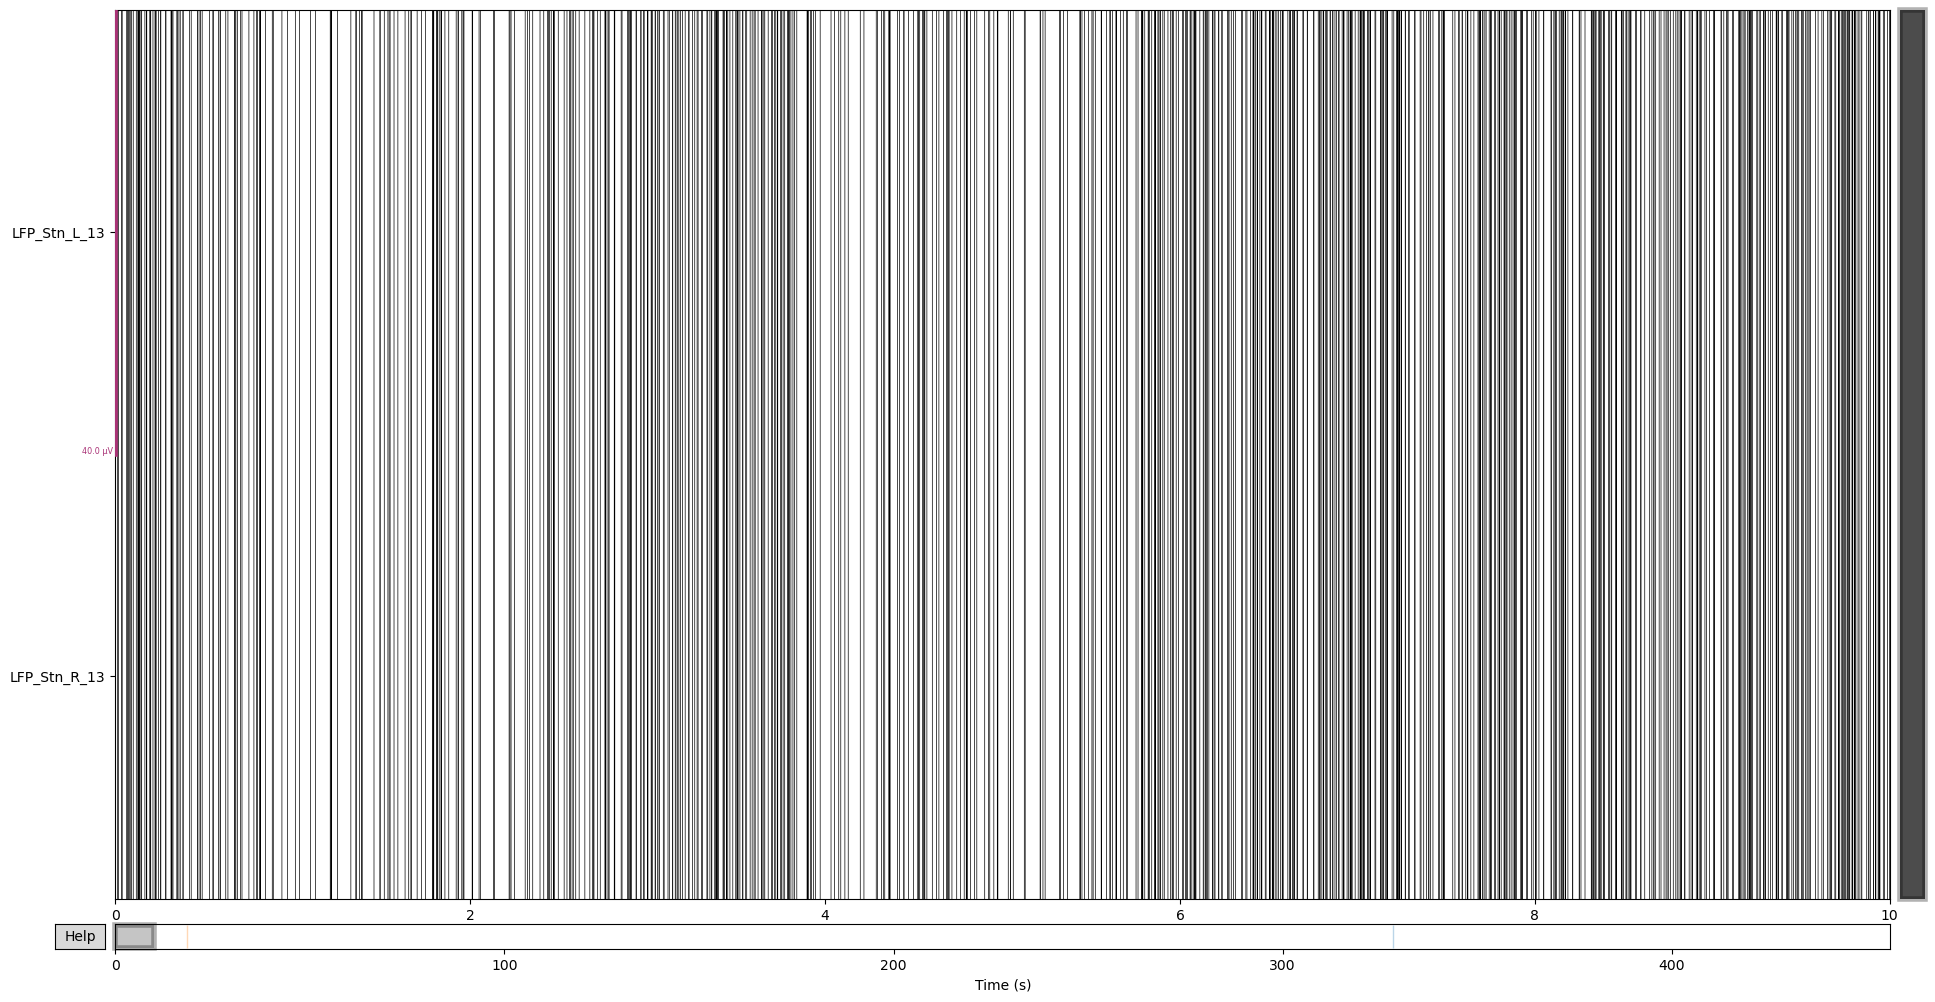

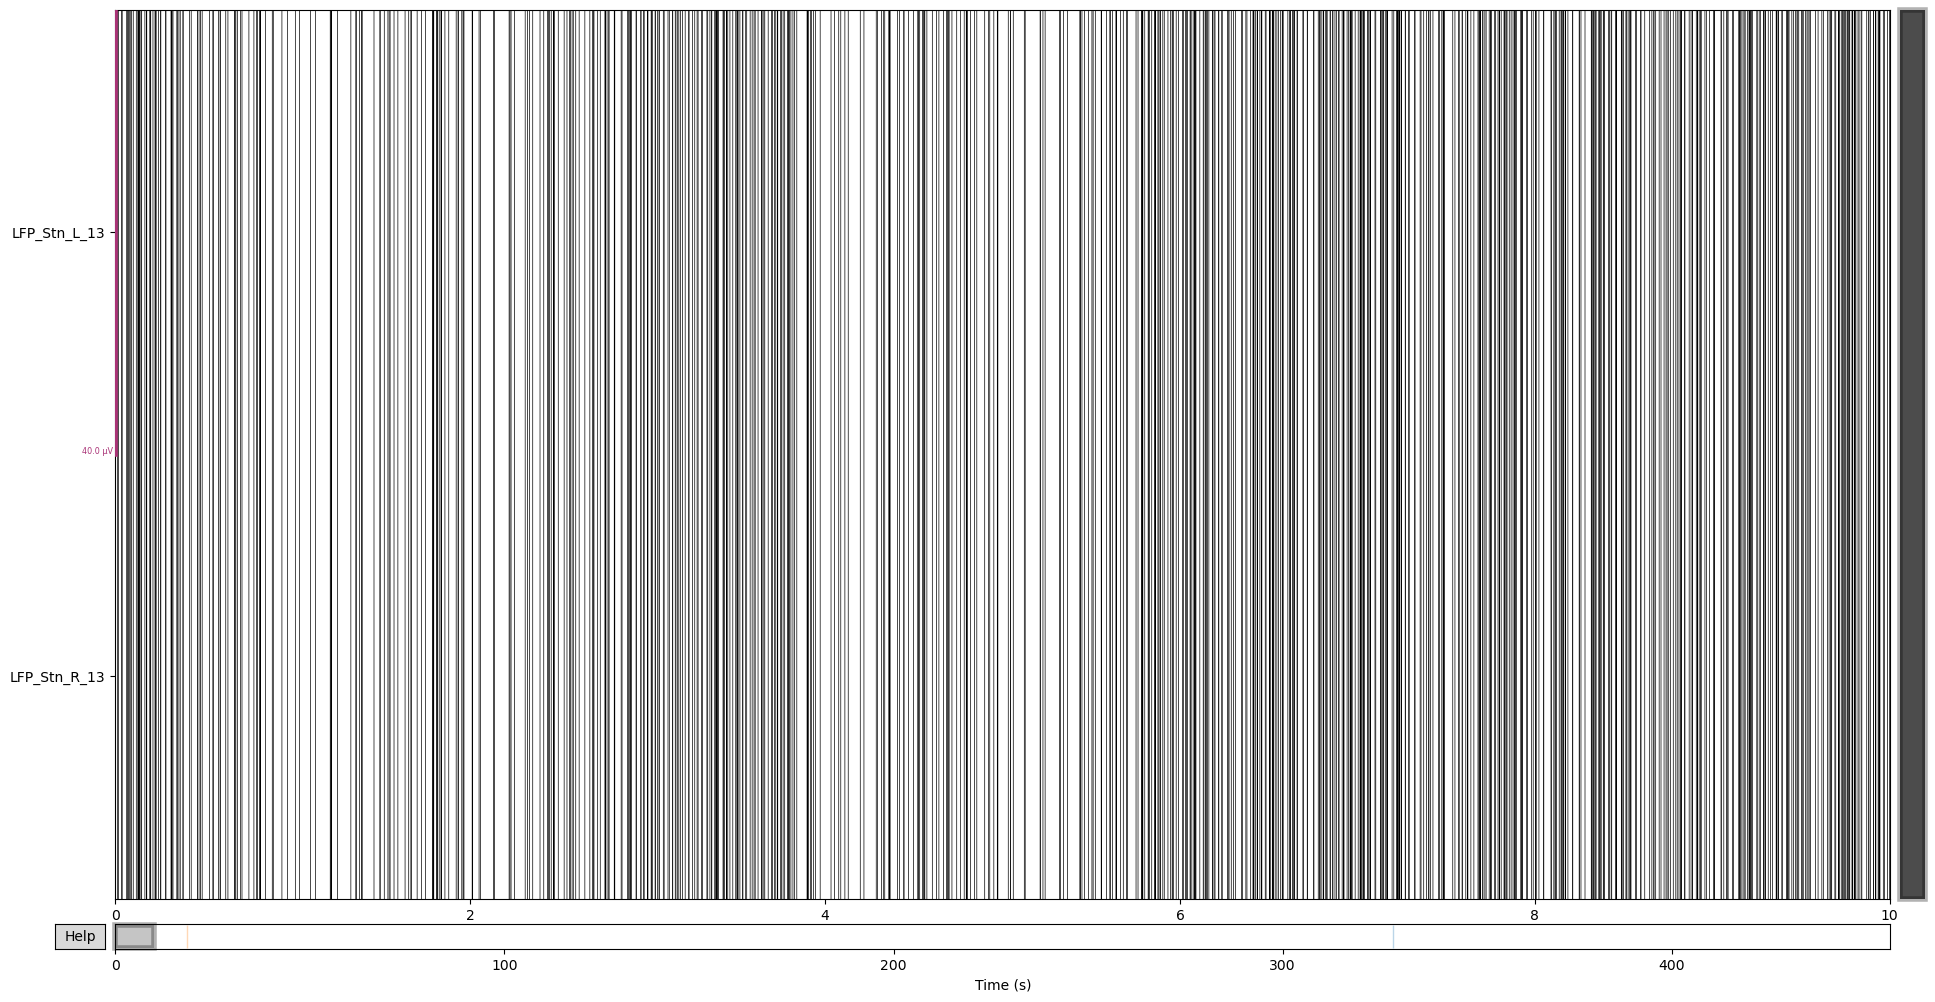

In [23]:
# Highpass filter at 1 Hz
lowpass_filtered_raw = deepcopy(raw).filter(l_freq=5, h_freq=None,picks=picks)
lowpass_filtered_raw.plot(picks=picks)


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 37 samples (0.148 s)



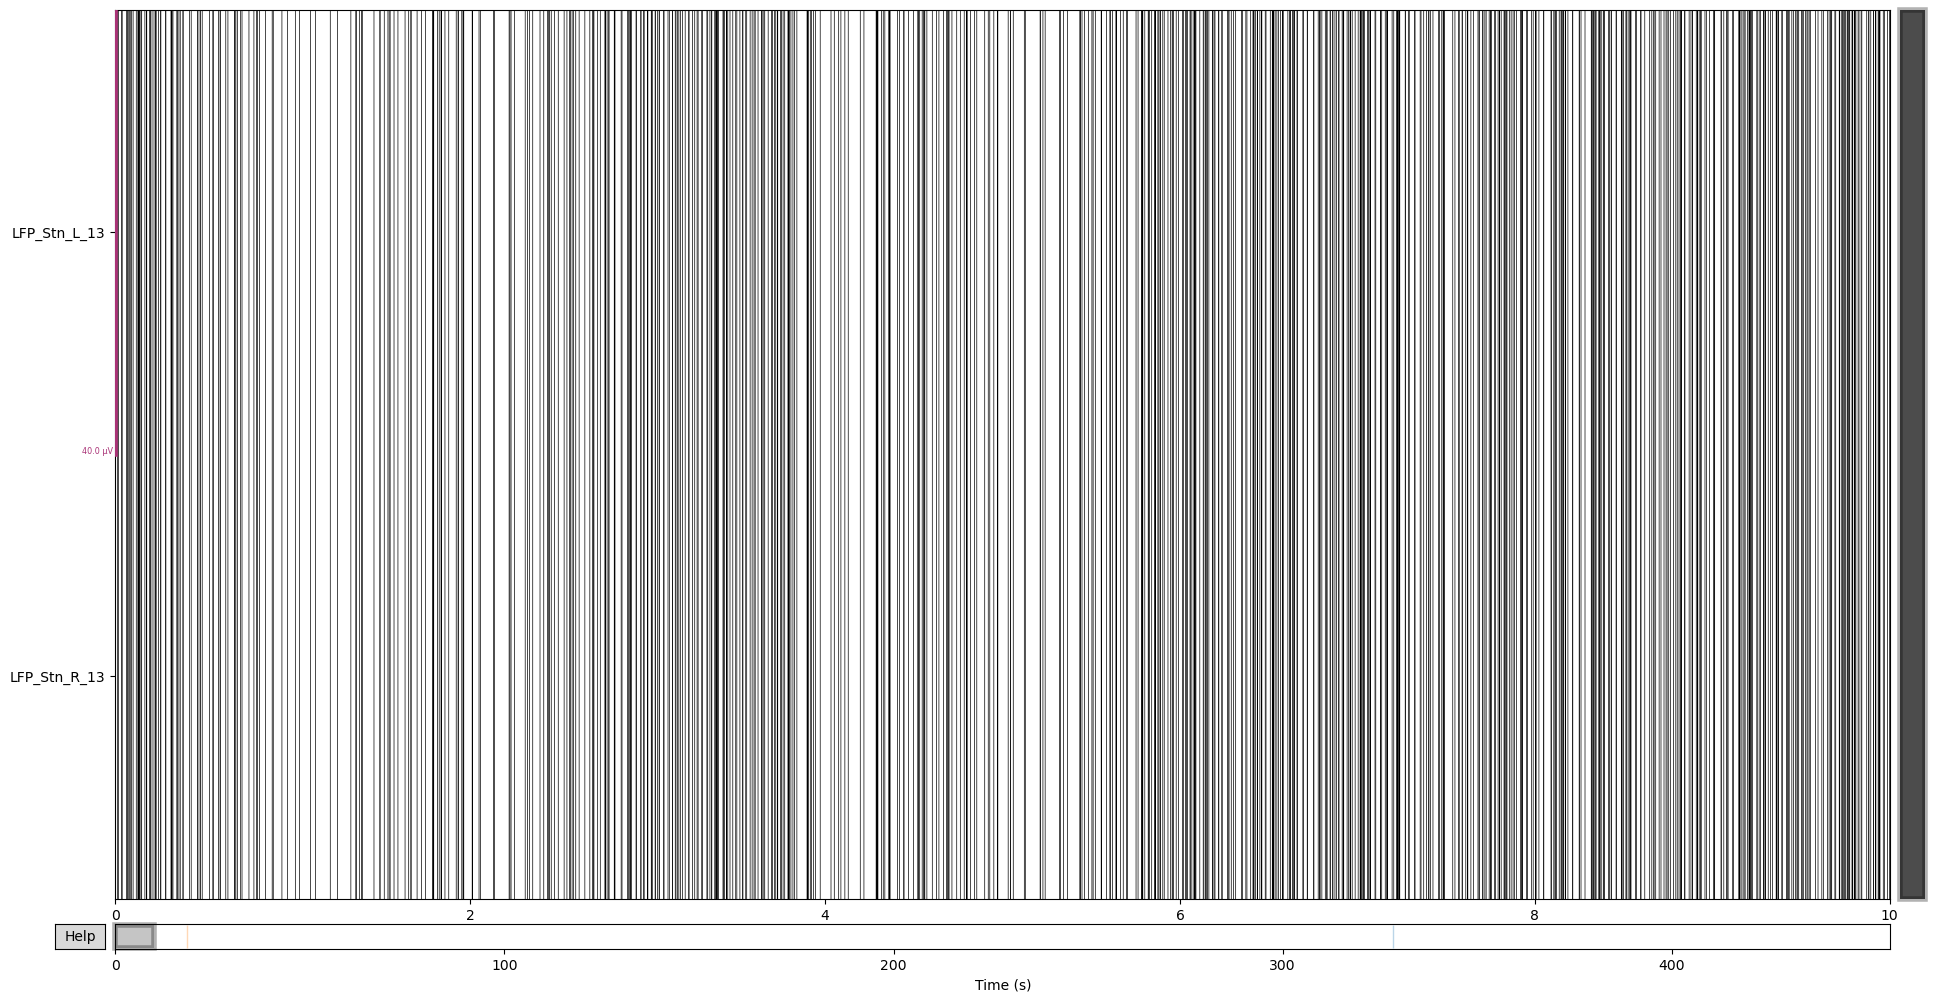

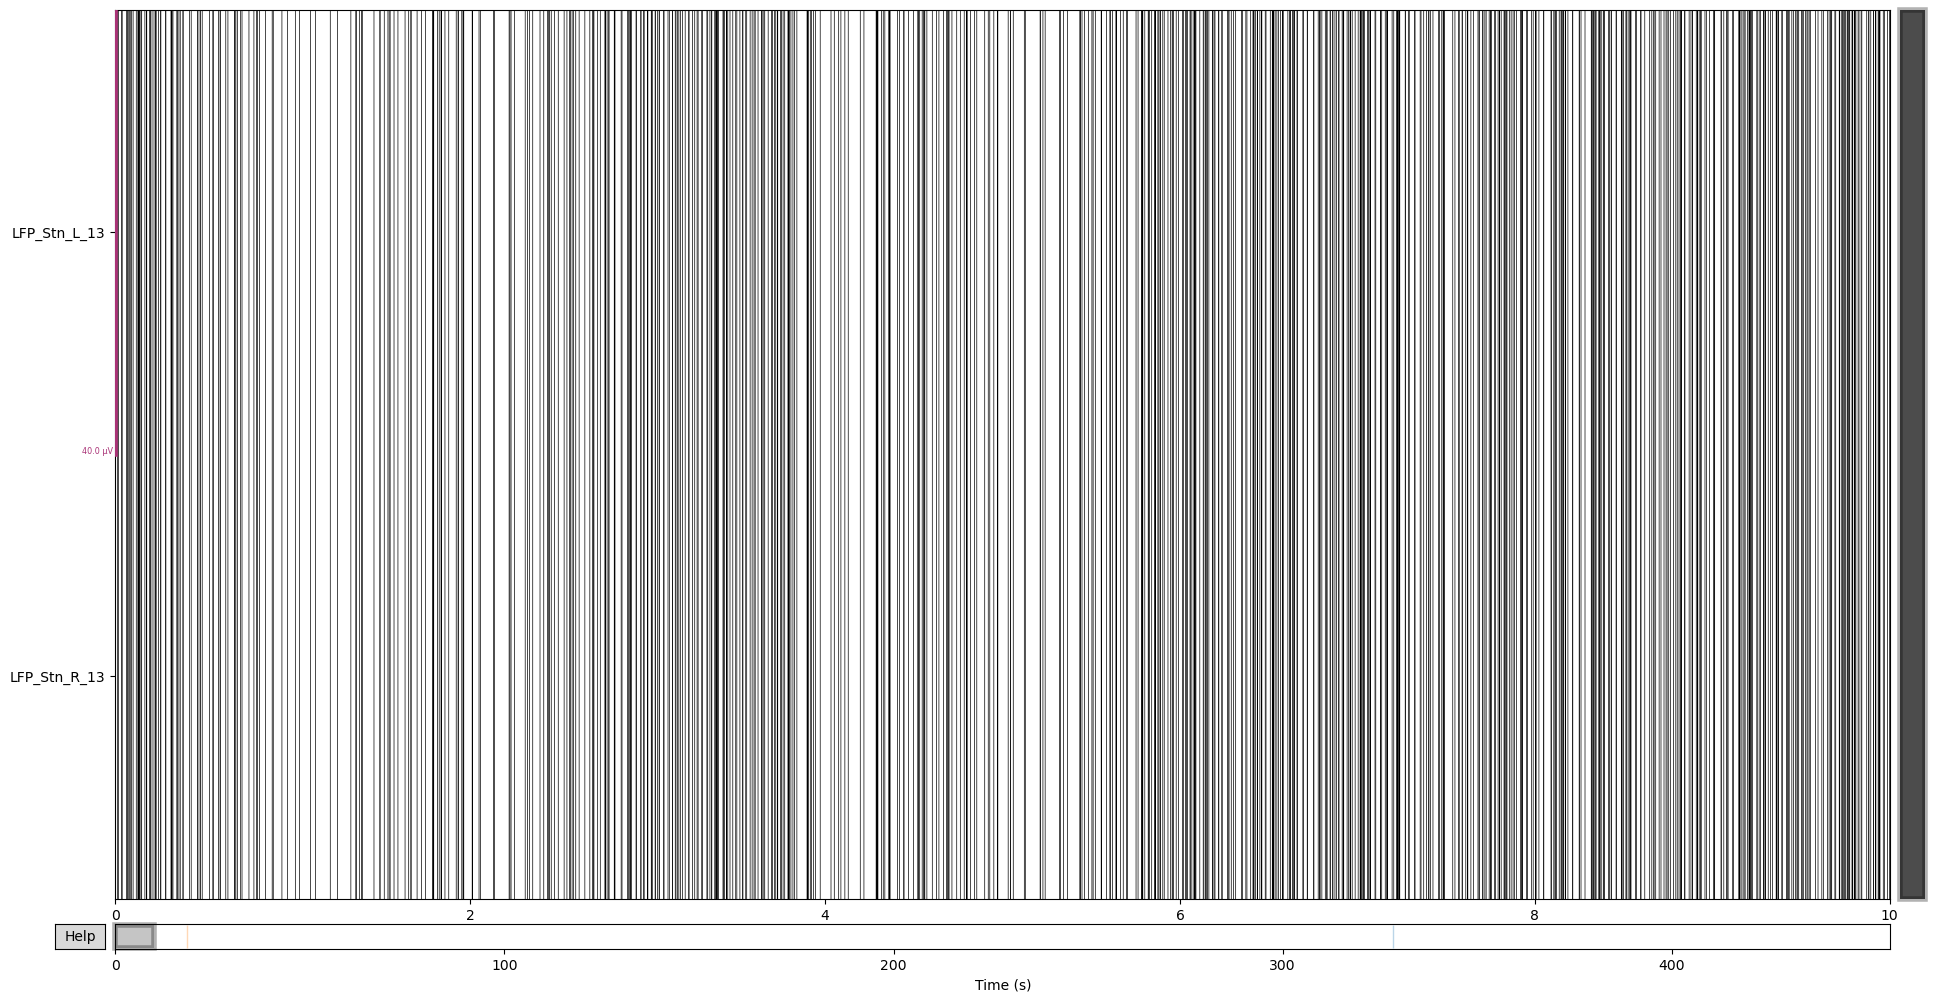

In [24]:
# Lowpass filter at 90 Hz
highpass_filtered_raw = deepcopy(lowpass_filtered_raw).filter(l_freq=None, h_freq=90, picks=picks)
highpass_filtered_raw.plot(picks=picks)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



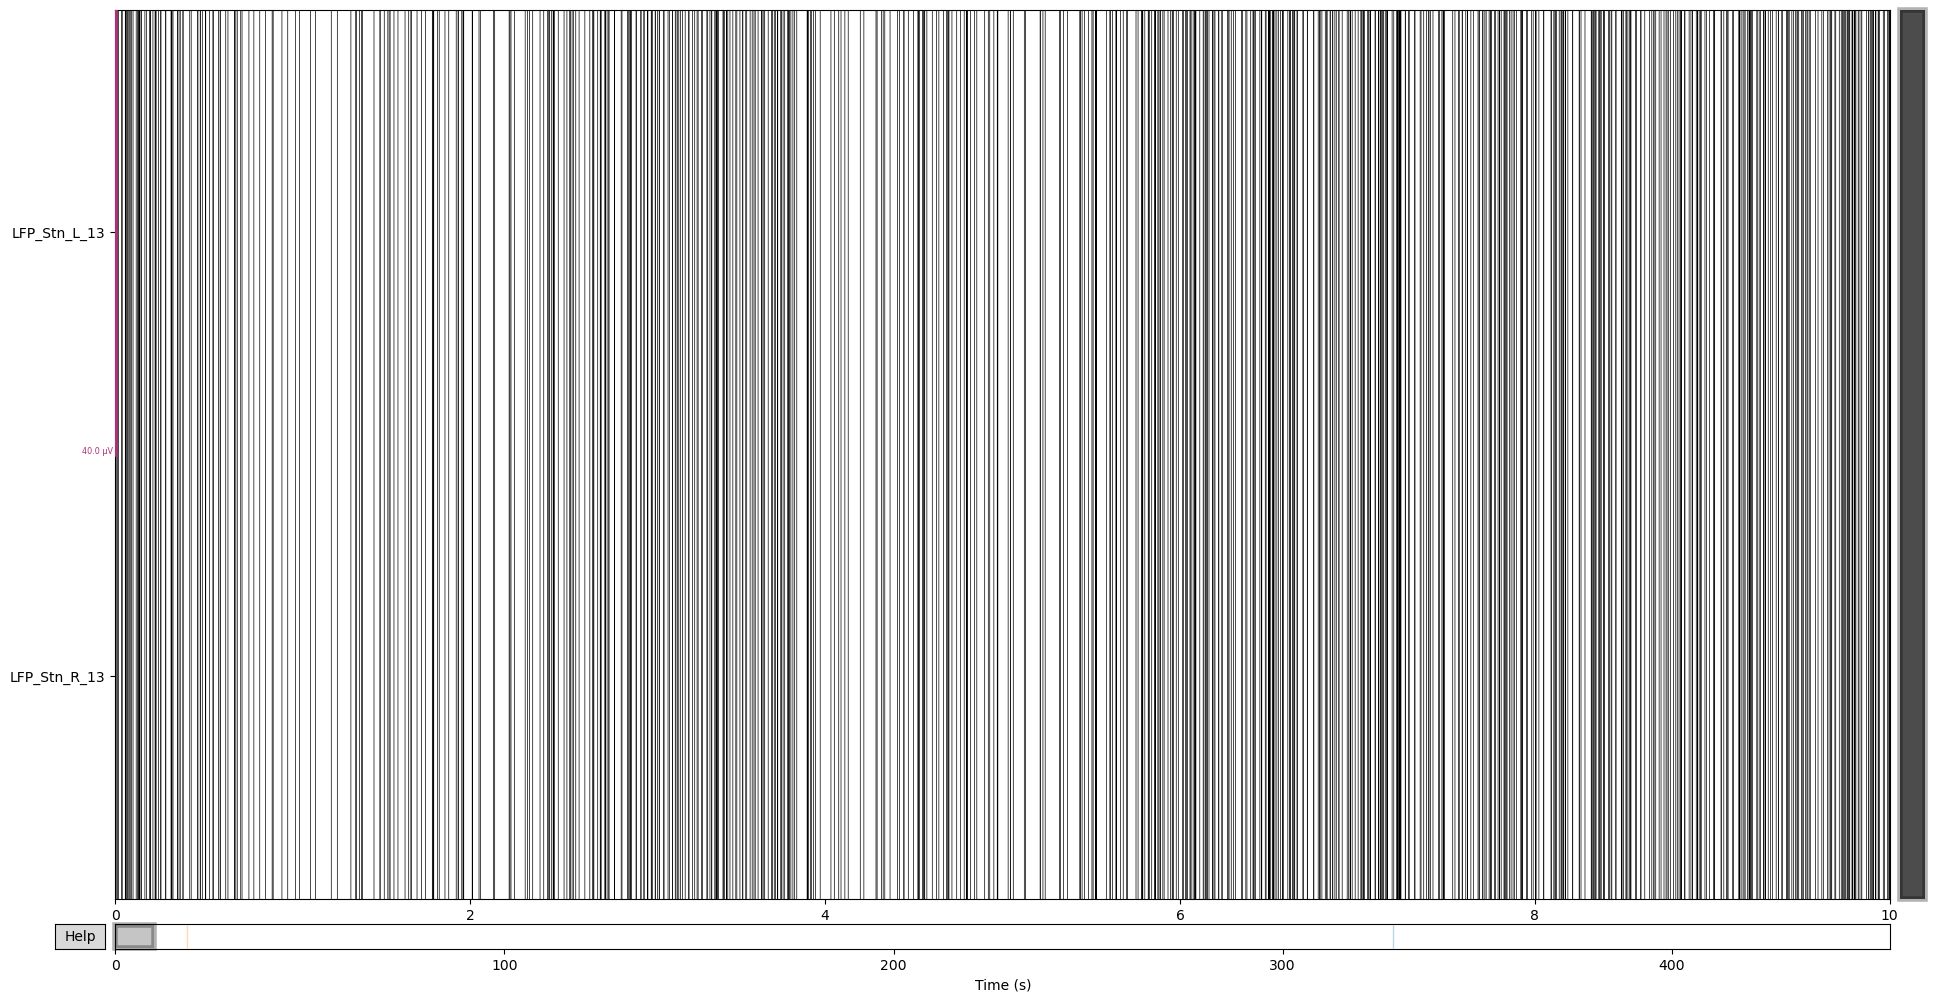

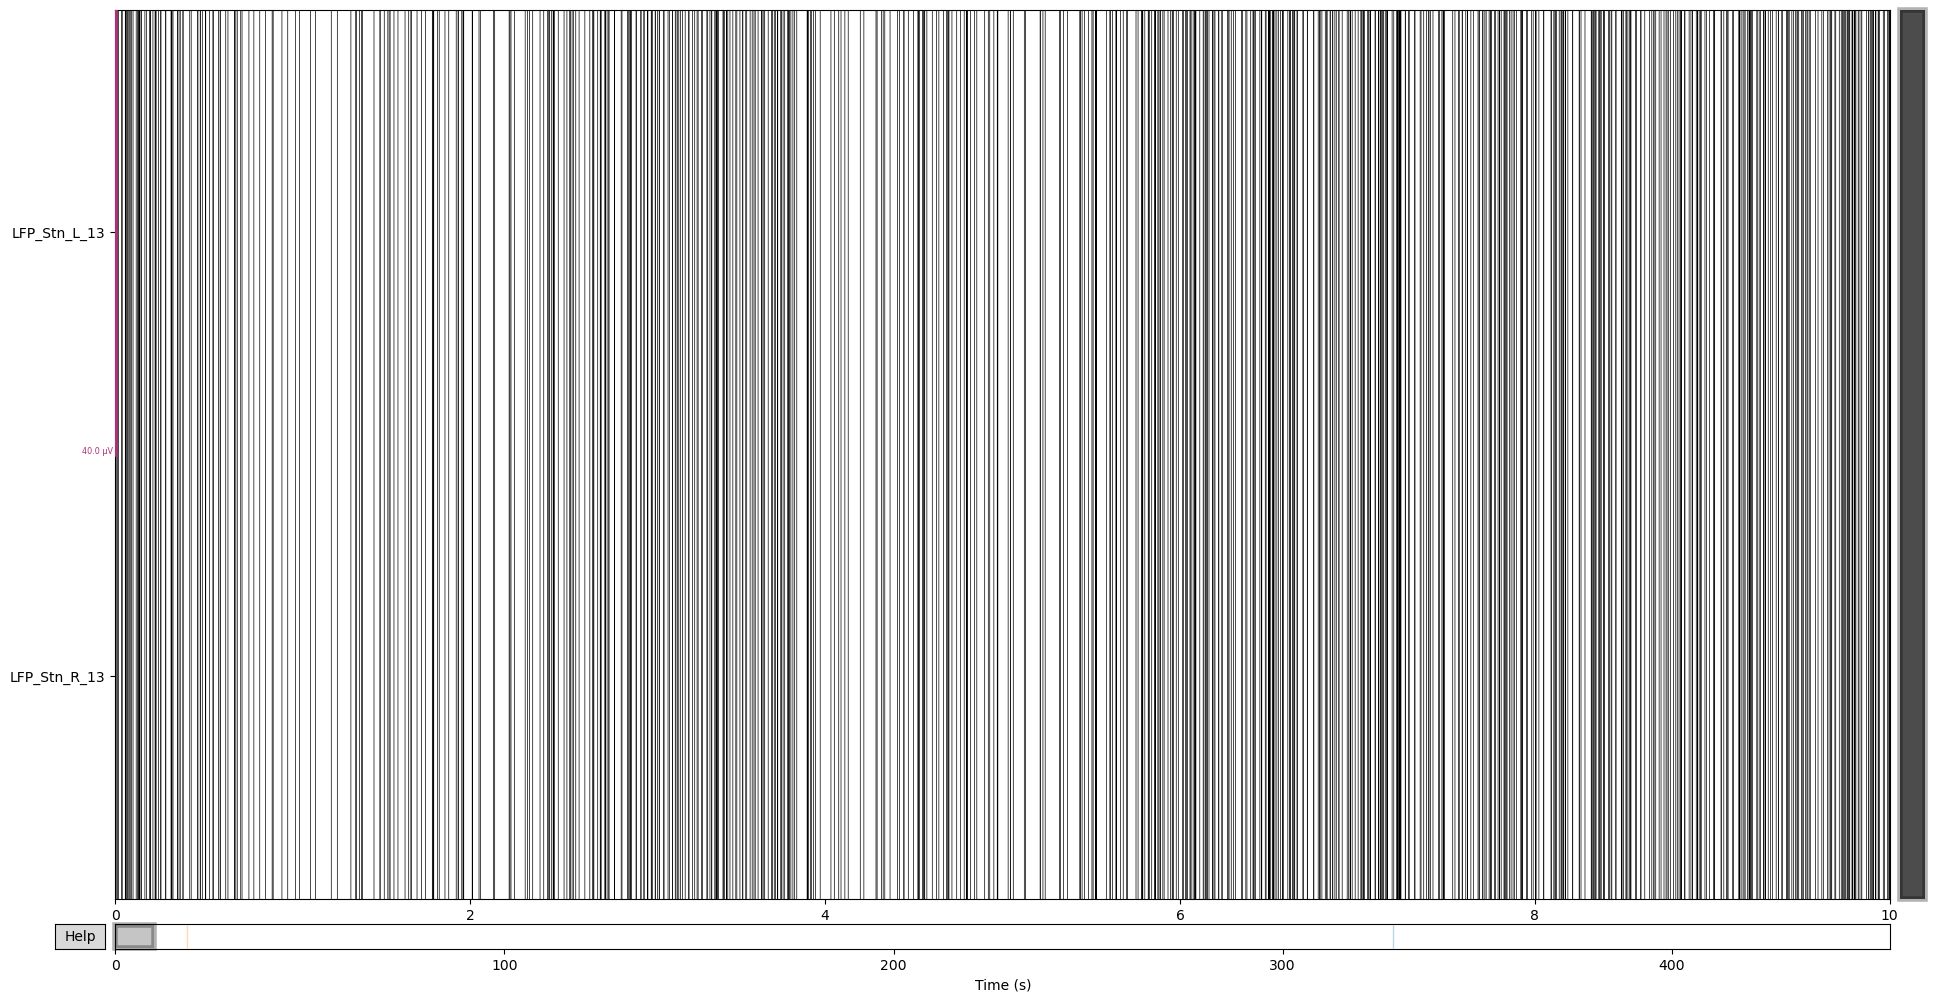

In [25]:
# Notch filter around 50 Hz (stop band)
notch_filtered_signal = deepcopy(highpass_filtered_raw).notch_filter(freqs=np.arange(50, 125, 50), picks=picks)
notch_filtered_signal.plot(picks=picks)

In [30]:
%matplotlib inline

C:\Users\Juliette\AppData\Local\Temp\ipykernel_3416\4058655347.py:6: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window, sym=False)


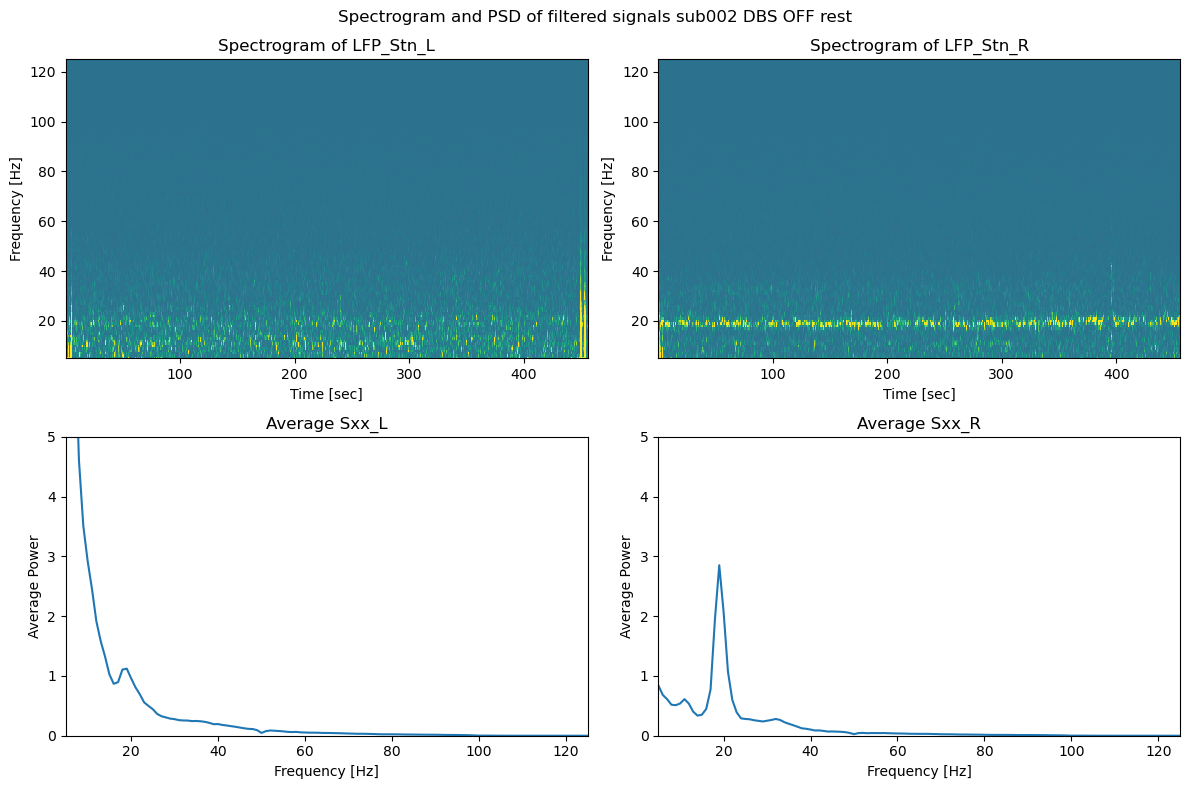

In [31]:
L_chan = notch_filtered_signal.get_data(picks=raw.ch_names[0])[0]
R_chan = notch_filtered_signal.get_data(picks=raw.ch_names[1])[0]
fs = round(raw.info['sfreq'])
window = fs # window length = 1 sec; frequencies will be from 0 to 125 Hz, 125Hz = Nyquist = fs/2
noverlap = window // 2 # 50% overlap of windows
window = hann(window, sym=False)

# Plot 1 data
frequencies_L, time_sectors_L, Sxx_L = spectrogram(x=L_chan, fs=fs, window=window, noverlap=noverlap, scaling='density', mode='psd', axis=0)

# Plot 2 data
frequencies_R, time_sectors_R, Sxx_R = spectrogram(x=R_chan, fs=fs, window=window, noverlap=noverlap, scaling='density', mode='psd', axis=0)

# Plot 3 data
average_Sxx_L = np.nanmean(Sxx_L, axis=1)
Sxx_std_L = np.std(Sxx_L, axis=1)  # standard deviation of each frequency row
Sxx_sem_L = Sxx_std_L / np.sqrt(Sxx_L.shape[1])

# Plot 4 data
average_Sxx_R = np.nanmean(Sxx_R, axis=1)
Sxx_std_R = np.std(Sxx_R, axis=1)  # standard deviation of each frequency row
Sxx_sem_R = Sxx_std_R / np.sqrt(Sxx_R.shape[1])

# Create a figure with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Top left
axs[0, 0].pcolormesh(time_sectors_L, frequencies_L, Sxx_L, vmin=-3, vmax=5)
axs[0, 0].set_ylim(5, 125)
axs[0, 0].set_ylabel('Frequency [Hz]')
axs[0, 0].set_xlabel('Time [sec]')
axs[0, 0].set_title('Spectrogram of LFP_Stn_L')

# Plot 2: Top right
axs[0, 1].pcolormesh(time_sectors_R, frequencies_R, Sxx_R, vmin=-3, vmax=5)
axs[0, 1].set_ylim(5, 125)
axs[0, 1].set_ylabel('Frequency [Hz]')
axs[0, 1].set_xlabel('Time [sec]')
axs[0, 1].set_title('Spectrogram of LFP_Stn_R')

# Plot 3: Bottom left
axs[1, 0].plot(average_Sxx_L)
axs[1, 0].set_xlim(5, 125)
axs[1, 0].set_ylim(0, 5)
axs[1, 0].set_title('Average Sxx_L')
axs[1, 0].set_ylabel('Average Power')
axs[1, 0].set_xlabel('Frequency [Hz]')

# Plot 4: Bottom right
axs[1, 1].plot(average_Sxx_R)
axs[1, 1].set_xlim(5, 125)
axs[1, 1].set_ylim(0, 5)
axs[1, 1].set_title('Average Sxx_R')
axs[1, 1].set_ylabel('Average Power')
axs[1, 1].set_xlabel('Frequency [Hz]')

# add a title at the top of the figure:
plt.suptitle('Spectrogram and PSD of filtered signals ' + session_ID)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(join(saving_path, (session_ID + ' spectrogram and PSD filtered signals.png')))

# Show the figure
plt.show()

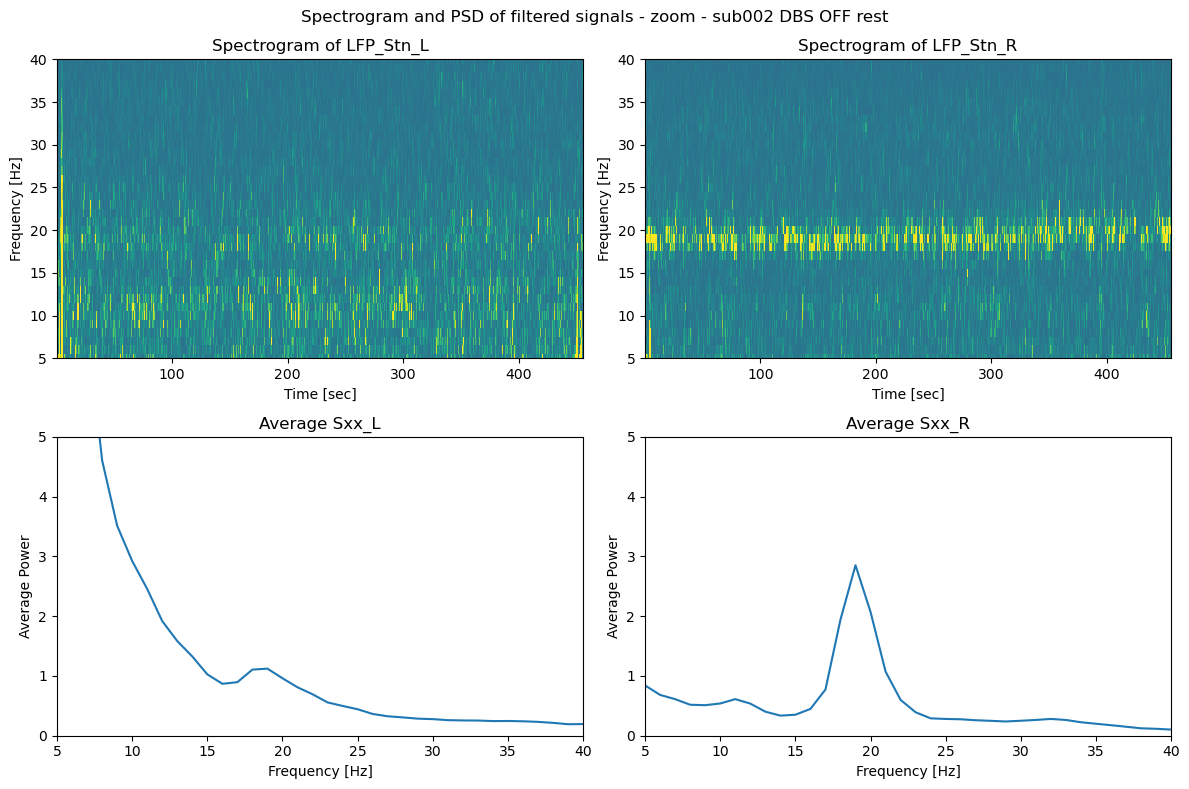

In [32]:
L_chan = notch_filtered_signal.get_data(picks=raw.ch_names[0])[0]
R_chan = notch_filtered_signal.get_data(picks=raw.ch_names[1])[0]

# Plot 1 data
frequencies_L, time_sectors_L, Sxx_L = spectrogram(x=L_chan, fs=fs, window=window, noverlap=noverlap, scaling='density', mode='psd', axis=0)

# Plot 2 data
frequencies_R, time_sectors_R, Sxx_R = spectrogram(x=R_chan, fs=fs, window=window, noverlap=noverlap, scaling='density', mode='psd', axis=0)

# Plot 3 data
average_Sxx_L = np.nanmean(Sxx_L, axis=1)
Sxx_std_L = np.std(Sxx_L, axis=1)  # standard deviation of each frequency row
Sxx_sem_L = Sxx_std_L / np.sqrt(Sxx_L.shape[1])

# Plot 4 data
average_Sxx_R = np.nanmean(Sxx_R, axis=1)
Sxx_std_R = np.std(Sxx_R, axis=1)  # standard deviation of each frequency row
Sxx_sem_R = Sxx_std_R / np.sqrt(Sxx_R.shape[1])

# Create a figure with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Top left
axs[0, 0].pcolormesh(time_sectors_L, frequencies_L, Sxx_L, vmin=-3, vmax=5)
axs[0, 0].set_ylim(5, 40)
axs[0, 0].set_ylabel('Frequency [Hz]')
axs[0, 0].set_xlabel('Time [sec]')
axs[0, 0].set_title('Spectrogram of LFP_Stn_L')

# Plot 2: Top right
axs[0, 1].pcolormesh(time_sectors_R, frequencies_R, Sxx_R, vmin=-3, vmax=5)
axs[0, 1].set_ylim(5, 40)
axs[0, 1].set_ylabel('Frequency [Hz]')
axs[0, 1].set_xlabel('Time [sec]')
axs[0, 1].set_title('Spectrogram of LFP_Stn_R')

# Plot 3: Bottom left
axs[1, 0].plot(average_Sxx_L)
axs[1, 0].set_xlim(5, 40)
axs[1, 0].set_ylim(0, 5)
axs[1, 0].set_title('Average Sxx_L')
axs[1, 0].set_ylabel('Average Power')
axs[1, 0].set_xlabel('Frequency [Hz]')

# Plot 4: Bottom right
axs[1, 1].plot(average_Sxx_R)
axs[1, 1].set_xlim(5, 40)
axs[1, 1].set_ylim(0, 5)
axs[1, 1].set_title('Average Sxx_R')
axs[1, 1].set_ylabel('Average Power')
axs[1, 1].set_xlabel('Frequency [Hz]')

# add a title at the top of the figure:
plt.suptitle('Spectrogram and PSD of filtered signals - zoom - ' + session_ID)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(join(saving_path, 'spectrogram and PSD filtered signals zoomed.png'))

# Show the figure
plt.show()

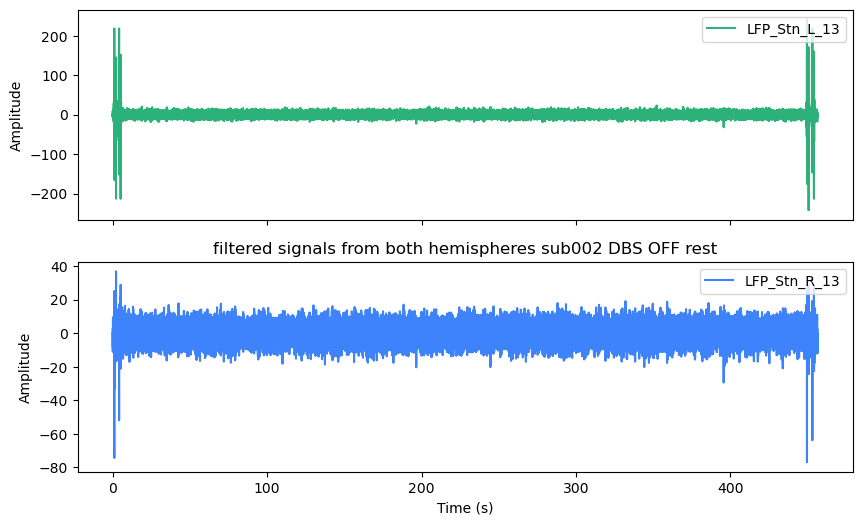

<Figure size 640x480 with 0 Axes>

In [21]:
# Plotting filtered signals
plot_signals(notch_filtered_signal.times, notch_filtered_signal.get_data(), picks, session_ID, title = ('filtered signals from both hemispheres ' + session_ID))
plt.show()
plt.savefig(join(saving_path, (session_ID + ' filtered signals from both hemispheres.png')))

Time-Frequency Analysis with consecutive fourier transforms

In [44]:
##### Function from Jenny's notebook #####

from scipy.signal import hann

def fourier_transform(signal:None):
    """
    Fourier transform with 50% overlap, window length of 1 second
    
    """
    fs = 250
    window = fs # window length = 1 sec; frequencies will be from 0 to 125 Hz, 125Hz = Nyquist = fs/2
    noverlap = window // 2 # 50% overlap of windows

    window = hann(window, sym=False)

    # compute spectrogram with Fourier Transforms

    f,time_sectors,Sxx = spectrogram(x=signal, fs=fs, window=window, noverlap=noverlap,  scaling='density', mode='psd', axis=0)
    # f = frequencies 0-125 Hz (Maximum = Nyquist frequency = sfreq/2)
    # time_sectors = sectors 0.5 - 20.5 s in 0.5 steps (in total 21 time sectors)
    # Sxx = 126 arrays with 21 values each of PSD [µV^2/Hz], for each frequency bin PSD values of each time sector
    # Sxx = 126 frequency rows, 21 time sector columns

    # average all 21 Power spectra of all time sectors 
    average_Sxx = np.mean(Sxx, axis=1) # axis = 1 -> mean of each column: in total 21x126 mean values for each frequency
                

    #################### CALCULATE THE STANDARD ERROR OF MEAN ####################
    # SEM = standard deviation / square root of sample size
    Sxx_std = np.std(Sxx, axis=1) # standard deviation of each frequency row
    Sxx_sem = Sxx_std / np.sqrt(Sxx.shape[1]) # sample size = 21 time vectors -> sem with 126 values

    return {
        "freq": f,
        "time_sectors": time_sectors,
        "Sxx": Sxx,
        "average_Sxx": average_Sxx,
        "Sxx_sem": Sxx_sem
    }


In [45]:
fourier_transform_lfp_L = fourier_transform(L_chan)

C:\Users\Juliette\AppData\Local\Temp\ipykernel_13272\1163960763.py:14: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window, sym=False)


In [ ]:
fourier_transform_lfp_L

Working with EPOCHS

In [82]:
%matplotlib qt

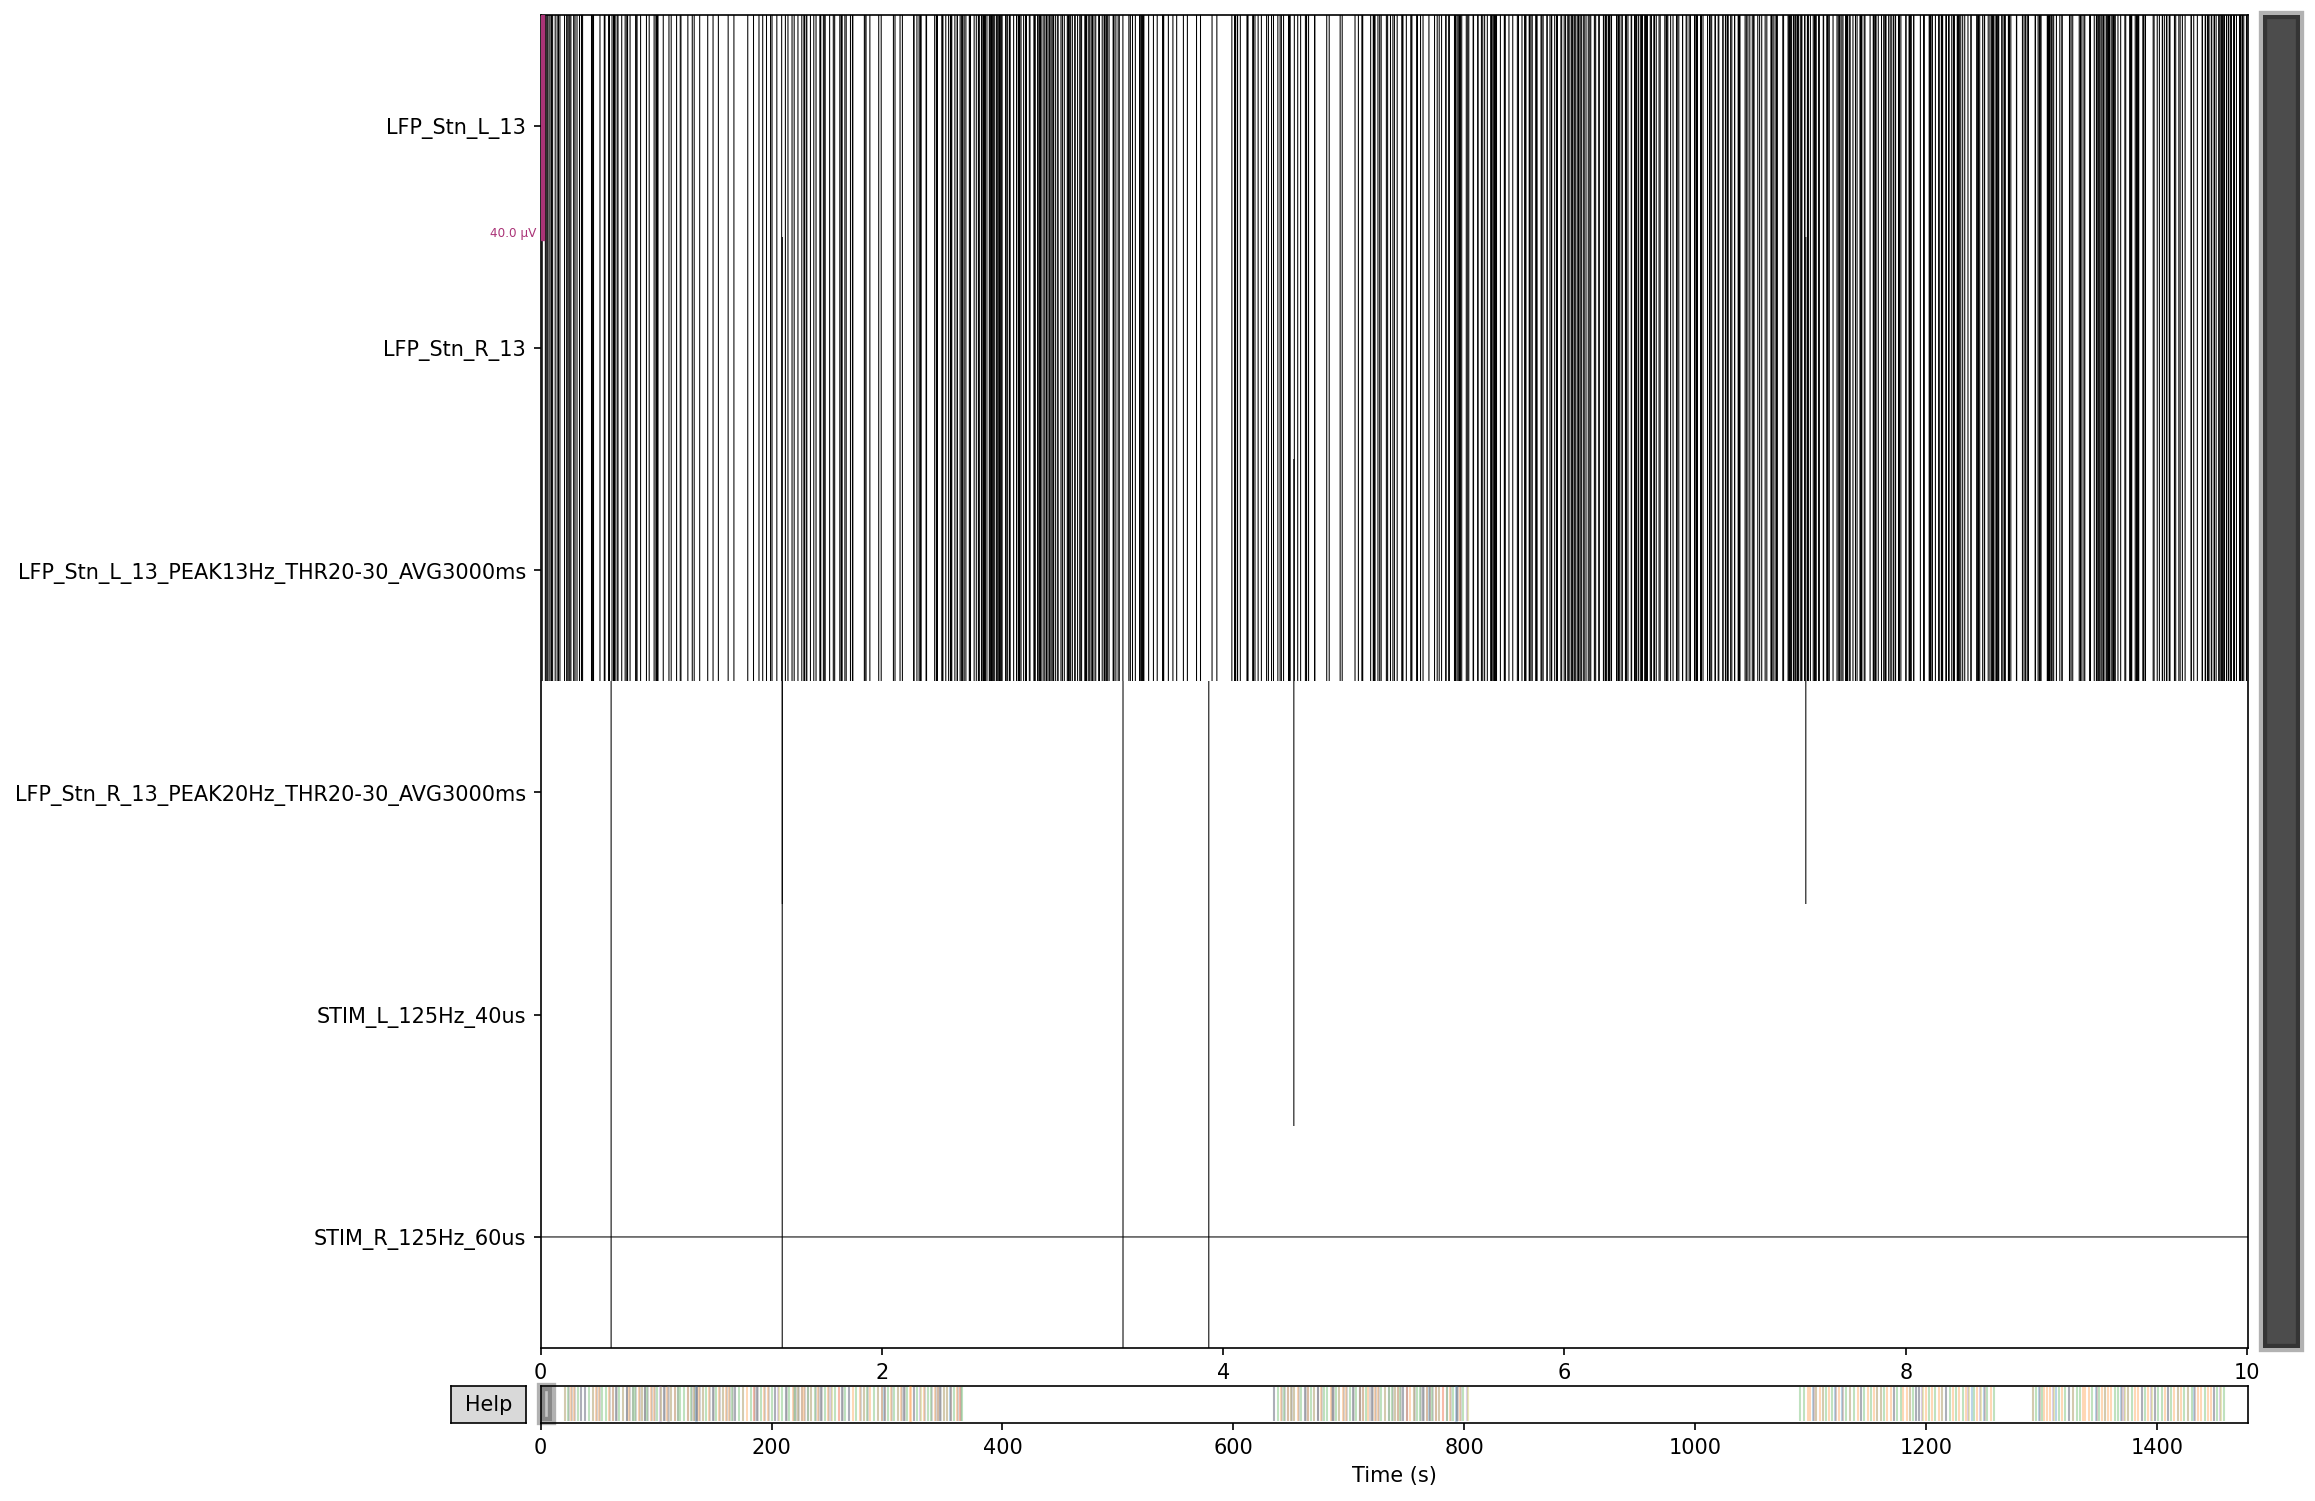

Channels marked as bad:
['LFP_Stn_L_13_PEAK13Hz_THR20-30_AVG3000ms', 'LFP_Stn_R_13_PEAK20Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_40us', 'STIM_R_125Hz_60us']


In [83]:
notch_filtered_signal.plot()

## Work with epochs ##

In [85]:
events, _ = mne.events_from_annotations(notch_filtered_signal)


Used Annotations descriptions: ['GC', 'GF', 'GO', 'GS', 'continue', 'early', 'resp', 'stop']


In [86]:
tmin, tmax = -1, 4
event_ids = dict(GC=1, GF=2, GO=3, GS=4, Cont=5, early=6, resp=7, stop=8)  # map event IDs to tasks

data = deepcopy(notch_filtered_signal)
epochs = mne.Epochs(data, events, event_id=[3, 8, 4, 2, 5, 1], tmin=tmin - 0.5, tmax= tmax + 0.5, baseline=None, preload=True)


Not setting metadata
398 matching events found


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 398 events and 1501 original time points ...
0 bad epochs dropped


In [87]:
event_ids

{'GC': 1,
 'GF': 2,
 'GO': 3,
 'GS': 4,
 'Cont': 5,
 'early': 6,
 'resp': 7,
 'stop': 8}

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


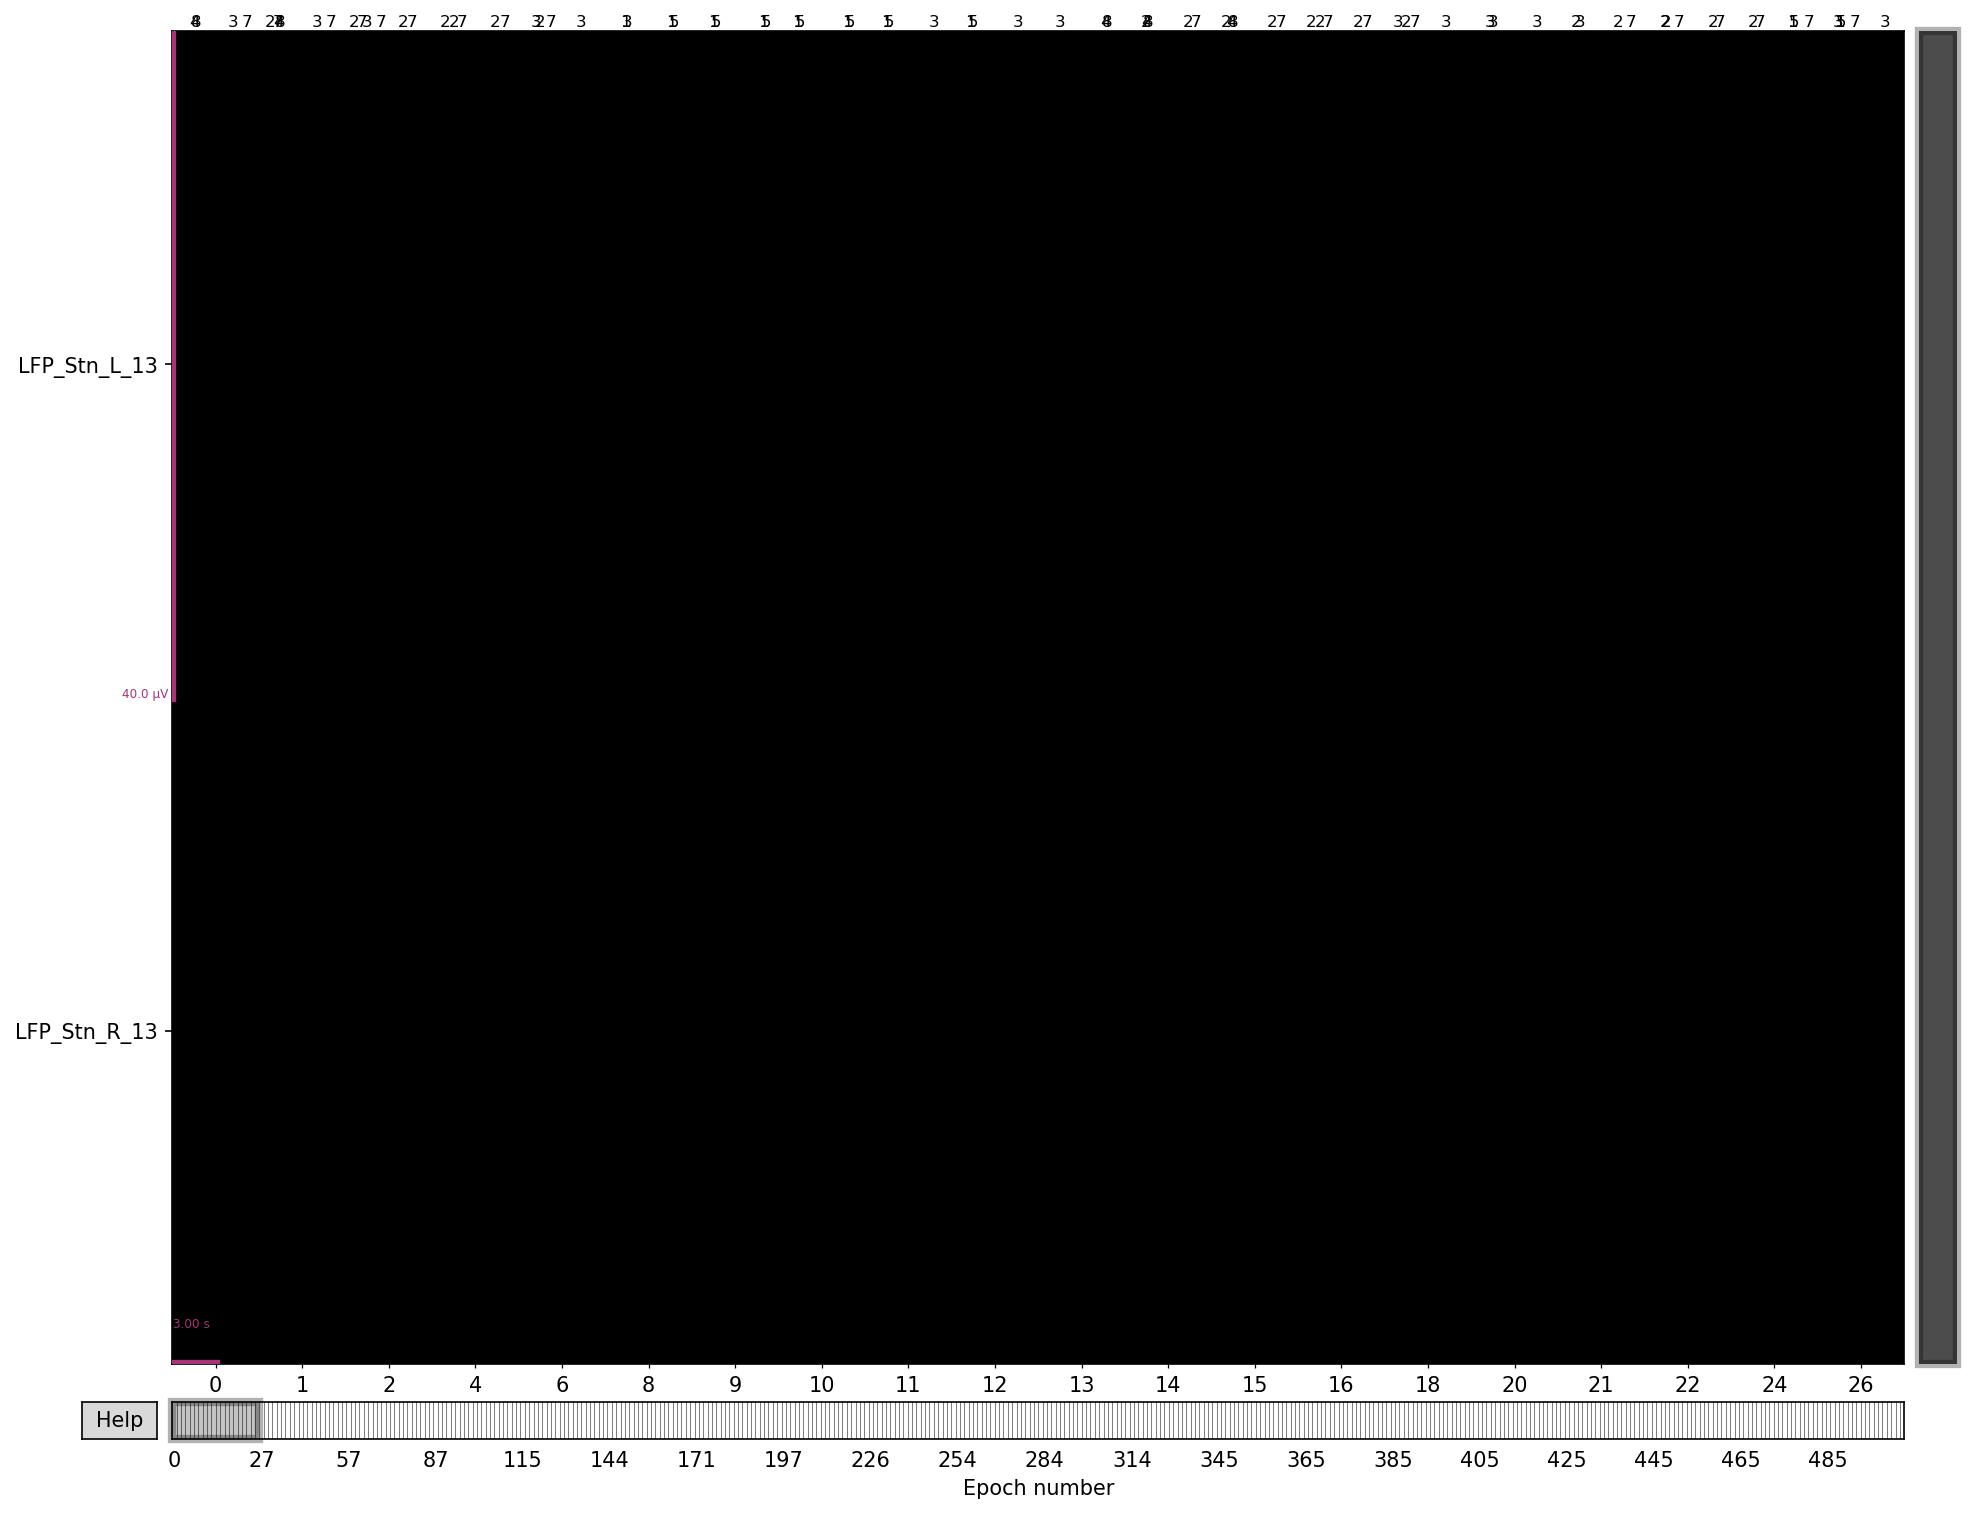

c:\Users\Juliette\anaconda3\envs\resync_xdf_new\Lib\site-packages\mne\viz\_figure.py:372: RuntimeWarning: Mean of empty slice
  data -= np.nanmean(data, axis=1, keepdims=True)


Dropped 5 epochs: 67, 68, 122, 123, 124
The following epochs were marked as bad and are dropped:
[97, 99, 174, 175, 176]
Channels marked as bad:
['LFP_Stn_L_13_PEAK13Hz_THR20-30_AVG3000ms', 'LFP_Stn_R_13_PEAK20Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_40us', 'STIM_R_125Hz_60us']


In [ ]:
epochs.plot(events=events, n_channels=2)

make ERDS map:

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test


In [90]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

In [120]:
tfr = epochs.compute_tfr(
    method="multitaper",
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)

In [112]:
tfr

Data type,Power Estimates
Data source,Epochs
Number of epochs,393
Dims,"epoch, channel, freq, time"
Estimation method,multitaper
Number of channels,2
Number of timepoints,751
Number of frequency bins,34
Frequency range,2.00 – 35.00 Hz


In [121]:
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


Data type,Power Estimates
Data source,Epochs
Number of epochs,393
Dims,"epoch, channel, freq, time"
Estimation method,multitaper
Number of channels,2
Number of timepoints,627
Number of frequency bins,34
Frequency range,2.00 – 35.00 Hz


In [134]:
tfr.shape

(393, 2, 34, 627)

In [122]:
tfr_ev = tfr[3]

In [132]:
# plot tfr for each condition:
tfr_ev.plot_topomap(
    picks=raw.ch_names[1],
    baseline=baseline,
    mode="percent",
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu_r",
    colorbar=True,
    show=True,
)

TypeError: EpochsTFR.plot_topomap() got an unexpected keyword argument 'picks'

In [119]:
for event in [3, 8, 4, 2, 5, 1]:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(X=tfr_ev.data[:, ch], threshold=None, n_permutations=100, tail=1, seed=1, step_down_p=0.05, out_type='mask', buffer_size=None)
        # negative clusters
        _, c2, p2, _ = pcluster_test(X=tfr_ev.data[:, ch], threshold=None, n_permutations=100, tail=-1, seed=1, step_down_p=0.05, out_type='mask', buffer_size=None)

        
        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Using a threshold of nan
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 0 clusters
Using a threshold of nan
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 0 clusters


c:\Users\Juliette\anaconda3\envs\resync_xdf_new\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Juliette\anaconda3\envs\resync_xdf_new\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
c:\Users\Juliette\anaconda3\envs\resync_xdf_new\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_13272\4193274314.py:9: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  _, c1, p1, _ = pcluster_test(X=tfr_ev.data[:, ch], threshold=None, n_permutations=100, tail=1, seed=1, step_down_p=0.05, out_type='mask', buffer_size=None)
C:\Users\Juliette\AppData\Local\Temp\ipykernel_13272\4193274314.py:11: RuntimeWarning: No clusters found, returning empty H0, cluster

ValueError: need at least one array to stack